In [1]:
import librosa
import sys
import random
import soundfile
import audioread
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from Datasets import SnippetProgDataset
from Utils import Utils
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import pandas as pd

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(f"The current device used is {device}")

The current device used is cuda


In [3]:
CLASS_NAMES = Utils.CLASS_NAMES

Number of Non-Prog songs: 359
Number of Prog songs: 142


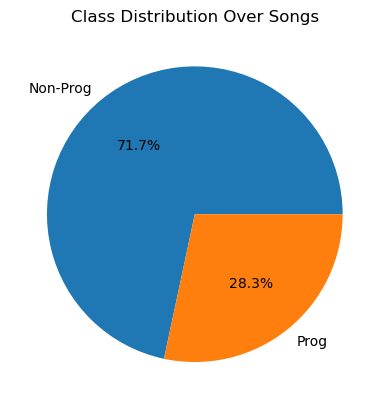

In [4]:
prog_folder = "Progressive_Rock_Songs"
non_prog_folder = "Not_Progressive_Rock"
prog_songs = [(i, Utils.getName(i), 1) for i in librosa.util.find_files(prog_folder)]
nonprog_songs = [(i, Utils.getName(i), 0) for i in librosa.util.find_files(non_prog_folder)]
songs =  prog_songs + nonprog_songs
for idx in range(len(CLASS_NAMES)):
    print(f"Number of {CLASS_NAMES[idx]} songs: {len([i for i in songs if i[2] == idx])}")
class_counts = [len([i for i in songs if i[2] == idx]) for idx in range(len(CLASS_NAMES))]
plt.pie(class_counts, labels=CLASS_NAMES, autopct='%1.1f%%')
plt.title('Class Distribution Over Songs')
plt.show()

In [5]:
random.seed(42)
random.shuffle(songs)
split_idx = int(0.8 * len(songs))
train_songs = songs[:split_idx]
validate_songs = songs[split_idx:]

Train|Number of Non-Prog songs: 292
Train|Number of Prog songs: 108


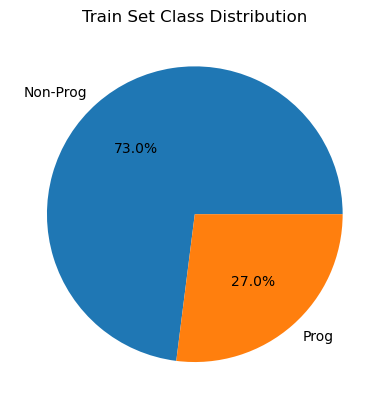

Validate|Number of Non-Prog songs: 67
Validate|Number of Prog songs: 34


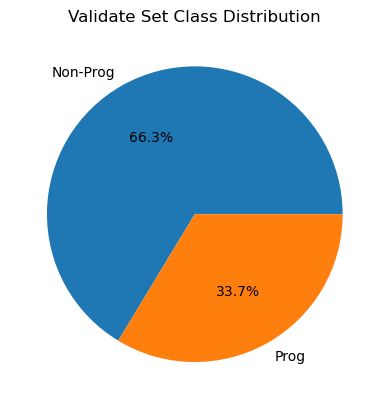

In [6]:
Utils.get_class_distribution(train_songs, "Train")
Utils.get_class_distribution(validate_songs, "Validate")

In [7]:
def load_file(file, snippet_length: int, sampling_rate: int):
    data, sr = librosa.load(file, sr = sampling_rate)
    data, trim_shape = librosa.effects.trim(data)
    sl = sr * snippet_length
    snippets = [data[i: i+sl] for i in range(0, len(data), sl)][:-1]
    return snippets

In [8]:
sampling_rate = 11025
song_path, song_name, label = train_songs[0]
snippets = load_file(song_path, 10, sampling_rate)
print(CLASS_NAMES[label], len(snippets))

Prog 50


In [9]:
class AudioFeatureExtractor():
    def __init__(self):
        pass

    def __call__(self, snippet):
        snippet = librosa.util.normalize(snippet)

        mel_spec = librosa.feature.melspectrogram(y = snippet, n_mels = 128)
        mfcc = librosa.feature.mfcc(y = snippet)
        chroma = librosa.feature.chroma_stft(y = snippet)

        features = np.concatenate((mel_spec, mfcc, chroma), axis=0)
        return features

In [10]:
audio_feature_extractor = AudioFeatureExtractor()
features = []
for snippet in snippets:
    features.append(audio_feature_extractor(snippet))
features = np.array(features)
print(features.shape)

(50, 160, 216)


In [11]:
class SpecAudioFeatureExtractor():
    def __init__(self, sr: int):
        self.sr = sr

    def __call__(self, snippet):
        snippet = librosa.util.normalize(snippet)

        mel_spec = librosa.feature.melspectrogram(y = snippet, n_mels = 128)
        mfcc = librosa.feature.mfcc(y = snippet)
        chroma = librosa.feature.chroma_stft(y = snippet)
        spec_cent = librosa.feature.spectral_centroid(y=snippet, sr=self.sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=snippet, sr=self.sr)
        tempo = librosa.feature.tempogram(y=snippet, sr=self.sr)
        onset_strength = librosa.onset.onset_strength(y=snippet, sr=self.sr).reshape(1, -1)
        rolloff = librosa.feature.spectral_rolloff(y=snippet, sr=self.sr)
        features = np.concatenate((mel_spec, mfcc, chroma, spec_cent, spec_bw, tempo, onset_strength, rolloff), axis=0)        
        return features

In [12]:
spec_audio_feature_extractor = SpecAudioFeatureExtractor(sampling_rate)
features = []
for snippet in snippets:
    features.append(spec_audio_feature_extractor(snippet))
features = np.array(features)
print(features.shape)

(50, 548, 216)


Mel-Spectogram: (128, 216)
MFCC: (20, 216)
Chromagram: (12, 216)


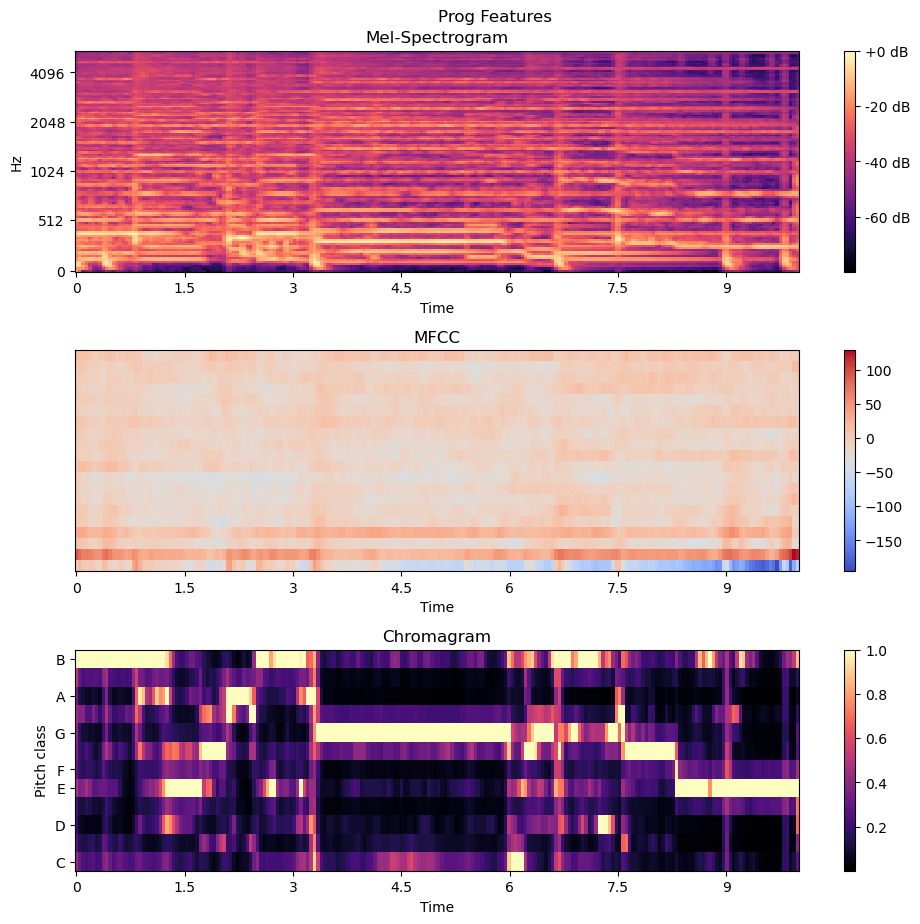

In [13]:
Utils.plot_features(features[5], label, sampling_rate)

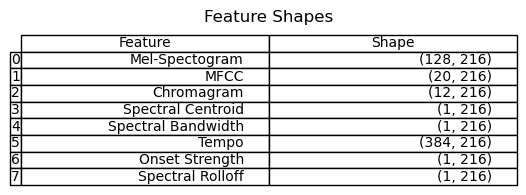

In [28]:
snippet = features[6]
mel_spec = snippet[:128, :]
mfcc = snippet[128 : 128 + 20, :]
chroma = snippet[128 + 20: 128 + 20 + 12, :]
spec_cent = snippet[128 + 20 + 12 : 128 + 20 + 12 + 1, :]
spec_bw = snippet[128 + 20 + 12 + 1 : 128 + 20 + 12 + 1 + 1, :]
tempo = snippet[128 + 20 + 12 + 1 + 1 : 128 + 20 + 12 + 1 + 1 + 384, :]
onset_strength = snippet[128 + 20 + 12 + 1 + 1 + 384 : 128 + 20 + 12 + 1 + 1 + 384 + 1, :]
rolloff = snippet[128 + 20 + 12 + 1 + 1 + 384 + 1 : 128 + 20 + 12 + 1 + 1 + 384 + 1 + 1, :]
names = ["Mel-Spectogram" ,"MFCC", "Chromagram", "Spectral Centroid", "Spectral Bandwidth", "Tempo", "Onset Strength", "Spectral Rolloff"]
shapes = [mel_spec.shape, mfcc.shape, chroma.shape, spec_cent.shape, spec_bw.shape, tempo.shape, onset_strength.shape, rolloff.shape]
tbl = []
for idx in range(len(names)):
    tbl.append([names[idx], shapes[idx]])
tbl = pd.DataFrame(tbl, columns=["Feature", "Shape"])
Utils.getTable(tbl, "Feature Shapes")

Mel-Spectogram: (128, 216)
MFCC: (20, 216)
Chromagram: (12, 216)
Spectral Centroid: (1, 216)
Spectral Bandwidth: (1, 216)
Tempo: (384, 216)
Onset Strength: (1, 216)
Spectral Rolloff: (1, 216)


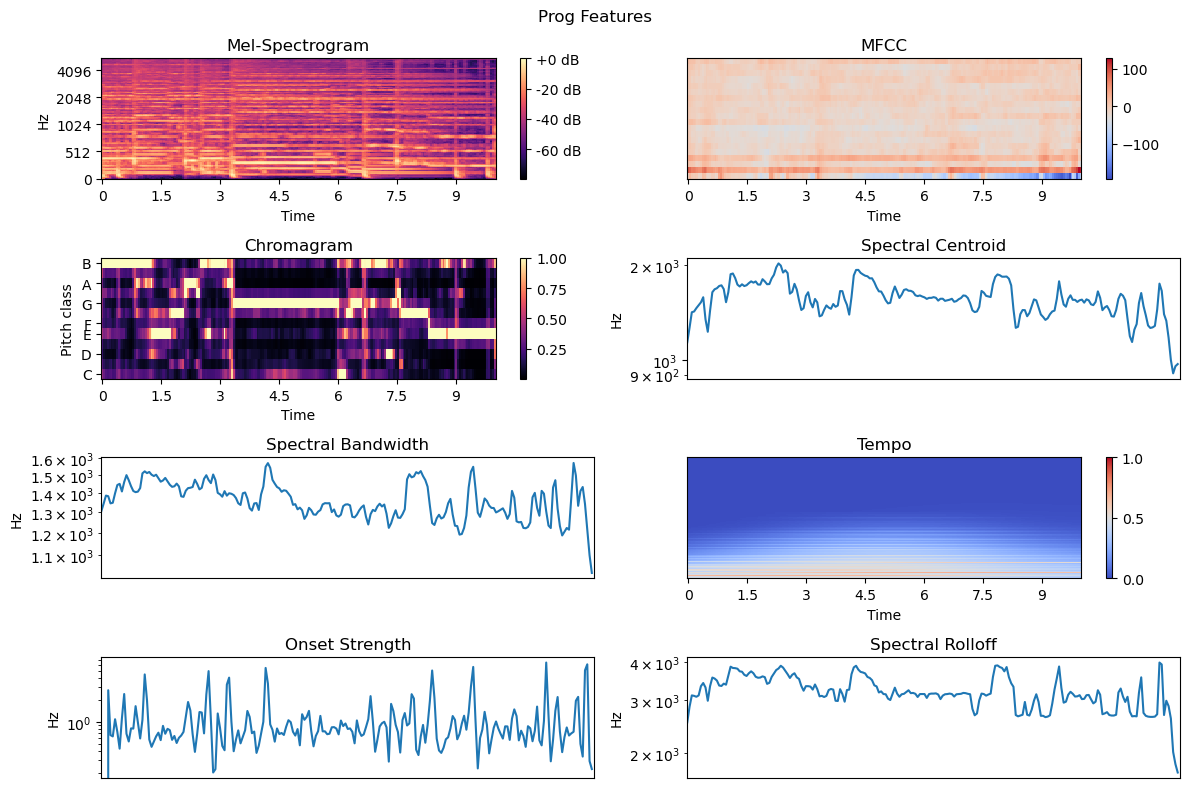

In [30]:
def plot_all_features(snippet, label, sr):
    mel_spec = snippet[:128, :]
    print(f"Mel-Spectogram: {mel_spec.shape}")
    mfcc = snippet[128 : 128 + 20, :]
    print(f"MFCC: {mfcc.shape}")
    chroma = snippet[128 + 20: 128 + 20 + 12, :]
    print(f"Chromagram: {chroma.shape}")
    spec_cent = snippet[128 + 20 + 12 : 128 + 20 + 12 + 1, :]
    print(f"Spectral Centroid: {spec_cent.shape}")
    spec_bw = snippet[128 + 20 + 12 + 1 : 128 + 20 + 12 + 1 + 1, :]
    print(f"Spectral Bandwidth: {spec_bw.shape}")
    tempo = snippet[128 + 20 + 12 + 1 + 1 : 128 + 20 + 12 + 1 + 1 + 384, :]
    print(f"Tempo: {tempo.shape}")
    onset_strength = snippet[128 + 20 + 12 + 1 + 1 + 384 : 128 + 20 + 12 + 1 + 1 + 384 + 1, :]
    print(f"Onset Strength: {onset_strength.shape}")
    rolloff = snippet[128 + 20 + 12 + 1 + 1 + 384 + 1 : 128 + 20 + 12 + 1 + 1 + 384 + 1 + 1, :]
    print(f"Spectral Rolloff: {rolloff.shape}")
    
    # Spectrogram
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{CLASS_NAMES[label]} Features")
    # plt.suptitle("{}".format("Progressive Rock" if 0 else "Non-Progressive Rock"))
    
    plt.subplot(4, 2, 1)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Mel-Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot the MFCCs
    plt.subplot(4, 2, 2)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.title('MFCC')
    plt.colorbar()
    
    # Plot the chromagram
    plt.subplot(4, 2, 3)
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.title('Chromagram')
    plt.colorbar()

    # Plot the Spectral Centroid
    plt.subplot(4, 2, 4)
    plt.semilogy(spec_cent.T, label='Spectral centroid')
    plt.ylabel('Hz')
    plt.xticks([])
    plt.xlim([0, spec_cent.shape[-1]])
    plt.title('Spectral Centroid')

    # Plot the Spectral Bandwidth
    plt.subplot(4, 2, 5)
    plt.semilogy(spec_bw.T, label='Spectral bandwidth')
    plt.ylabel('Hz')
    plt.xticks([])
    plt.xlim([0, spec_bw.shape[-1]])
    plt.title('Spectral Bandwidth')

    # Plot the Tempo
    plt.subplot(4, 2, 6)
    librosa.display.specshow(tempo, sr=sr, x_axis='time')
    plt.title('Tempo')
    plt.colorbar()

    # Plot the Onset Strength
    plt.subplot(4, 2, 7)
    plt.semilogy(onset_strength.T, label='Onset Strength')
    plt.ylabel('Hz')
    plt.xticks([])
    plt.xlim([0, onset_strength.shape[-1]])
    plt.title('Onset Strength')

    # Plot the Spectral Rolloff
    plt.subplot(4, 2, 8)
    plt.semilogy(rolloff.T, label='Spectral Rolloff')
    plt.ylabel('Hz')
    plt.xticks([])
    plt.xlim([0, rolloff.shape[-1]])
    plt.title('Spectral Rolloff')
    
    plt.tight_layout()
    plt.show()

plot_all_features(features[5], label, sampling_rate)